In [168]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, Birch
from fcmeans import FCM
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score, normalized_mutual_info_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import mixed_precision
import os
from scipy.cluster.hierarchy import linkage, dendrogram
%matplotlib inline

In [169]:

gpus = tf.config.experimental.list_physical_devices('GPU')
for g in gpus:
    tf.config.experimental.set_memory_growth(g, False)

# Enable XLA (fuses kernels)
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2'
tf.config.optimizer.set_jit(True)

# 2) Enable mixed-precision for Tensor Cores on the T4
mixed_precision.set_global_policy('mixed_float16')
print("Compute dtype:", mixed_precision.global_policy().compute_dtype)
print("Variable dtype:", mixed_precision.global_policy().variable_dtype)

print("GPUs available:", tf.config.list_physical_devices('GPU'))
!nvidia-smi                              # shows GPU status and memory

Compute dtype: float16
Variable dtype: float32
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Wed May  7 23:45:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|         

In [170]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Configuration
DATA_PATH = '/content/drive/MyDrive/Cluster_4342/shuffled_diabetes_data.csv'
FEATURES = [
    'Age','Sex','HighChol','CholCheck','BMI','Smoker',
    'HeartDiseaseorAttack','PhysActivity','Fruits','Veggies',
    'HvyAlcoholConsump','GenHlth','MentHlth','PhysHlth',
    'DiffWalk','Stroke','HighBP'
]
OUTCOME_COL = 'Diabetes'
MAX_ROWS = 5000
MAX_K = 20
EPS_VALUES = np.linspace(0.05, 2.0, 40)
MIN_SAMPLES_LIST = [3,5,10,20,50]
COV_TYPES = ['full','tied','diag','spherical']
FCM_M_RANGE = np.arange(1.5, 5.1, 0.5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [171]:
# Load and preprocess data
data = pd.read_csv(DATA_PATH, usecols=FEATURES + [OUTCOME_COL], nrows=MAX_ROWS).astype('float32')
X_df = data[FEATURES].fillna(data[FEATURES].median())
X = StandardScaler().fit_transform(X_df)
y_true = data[OUTCOME_COL].values

print(f"Loaded {X.shape[0]} samples, {X.shape[1]} features")

Loaded 5000 samples, 17 features


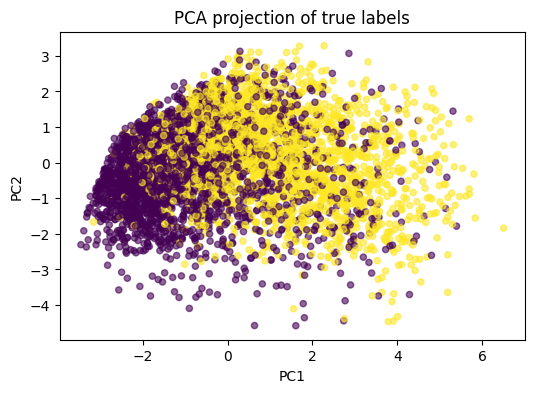

In [172]:
# PCA for visualization
pca = PCA(n_components=2, svd_solver='randomized')
X_pca = pca.fit_transform(X)
plt.figure(figsize=(6,4))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_true, s=20, alpha=0.6)
plt.title('PCA projection of true labels')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.show()

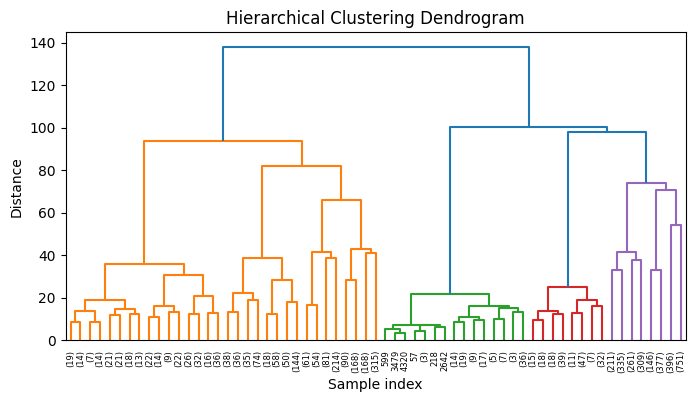

In [173]:
# Hierarchical clustering dendrogram
Z = linkage(X, method='ward')
plt.figure(figsize=(8,4))
dendrogram(Z, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index'); plt.ylabel('Distance'); plt.show()

In [174]:
# Hyperparameter tuning
results_tuning = {}

# 1. KMeans, Hierarchical, Birch: sweep n_clusters
for name, Model in [('KMeans', KMeans), ('Hierarchical', AgglomerativeClustering), ('Birch', Birch)]:
    best = {'sil': -np.inf, 'k': None}
    for k in range(2, MAX_K+1):
        if name == 'Hierarchical':
            labels = Model(n_clusters=k, linkage='ward').fit_predict(X)
        else:
            labels = Model(n_clusters=k).fit_predict(X)
        sil = silhouette_score(X, labels)
        if sil > best['sil']:
            best.update({'sil': sil, 'k': k})
    results_tuning[name] = best
    print(f"Tuned {name}: k={best['k']} (silhouette={best['sil']:.3f})")

# 2. DBSCAN: sweep eps and min_samples
best_db = {'sil': -np.inf, 'eps': None, 'min_samples': None}
for eps in EPS_VALUES:
    for ms in MIN_SAMPLES_LIST:
        labels = DBSCAN(eps=eps, min_samples=ms).fit_predict(X)
        unique = set(labels) - {-1}
        if len(unique) > 1:
            sil = silhouette_score(X, labels)
            if sil > best_db['sil']:
                best_db.update({'sil': sil, 'eps': eps, 'min_samples': ms})
results_tuning['DBSCAN'] = best_db
print(f"Tuned DBSCAN: eps={best_db['eps']:.2f}, min_samples={best_db['min_samples']} (silhouette={best_db['sil']:.3f})")

# 3. GaussianMixture: sweep n_components and covariance_type
best_gmm = {'sil': -np.inf, 'k': None, 'cov': None}
for k in range(2, MAX_K+1):
    for cov in COV_TYPES:
        try:
            labels = GaussianMixture(n_components=k, covariance_type=cov, random_state=42, reg_covar=1e-6).fit_predict(X)
            sil = silhouette_score(X, labels)
            if sil > best_gmm['sil']:
                best_gmm.update({'sil': sil, 'k': k, 'cov': cov})
        except Exception:
            continue
results_tuning['GMM'] = best_gmm
print(f"Tuned GMM: k={best_gmm['k']}, cov_type={best_gmm['cov']} (silhouette={best_gmm['sil']:.3f})")

# 4. Fuzzy C-Means: sweep n_clusters and m
best_fcm = {'sil': -np.inf, 'k': None, 'm': None}
for k in range(2, MAX_K+1):
    for m in FCM_M_RANGE:
        fcm = FCM(n_clusters=k, m=m)
        fcm.fit(X)
        labels = fcm.u.argmax(axis=1)
        sil = silhouette_score(X, labels)
        if sil > best_fcm['sil']:
            best_fcm.update({'sil': sil, 'k': k, 'm': m})
results_tuning['FuzzyCMeans'] = best_fcm
print(f"Tuned FuzzyCMeans: k={best_fcm['k']}, m={best_fcm['m']} (silhouette={best_fcm['sil']:.3f})")


Tuned KMeans: k=2 (silhouette=0.183)
Tuned Hierarchical: k=6 (silhouette=0.180)
Tuned Birch: k=6 (silhouette=0.181)
Tuned DBSCAN: eps=2.00, min_samples=3 (silhouette=0.076)
Tuned GMM: k=2, cov_type=spherical (silhouette=0.160)
Tuned FuzzyCMeans: k=2, m=1.5 (silhouette=0.145)


In [175]:
# Final clustering with tuned parameters
models = [
    ('KMeans', KMeans(n_clusters=results_tuning['KMeans']['k'], random_state=42)),
    ('Hierarchical', AgglomerativeClustering(n_clusters=results_tuning['Hierarchical']['k'], linkage='ward')),
    ('Birch', Birch(n_clusters=results_tuning['Birch']['k'])),
    ('DBSCAN', DBSCAN(eps=results_tuning['DBSCAN']['eps'], min_samples=results_tuning['DBSCAN']['min_samples'])),
    ('GMM', GaussianMixture(n_components=results_tuning['GMM']['k'], covariance_type=results_tuning['GMM']['cov'], random_state=42, reg_covar=1e-6)),
    ('FuzzyCMeans', FCM(n_clusters=results_tuning['FuzzyCMeans']['k'], m=results_tuning['FuzzyCMeans']['m']))
]

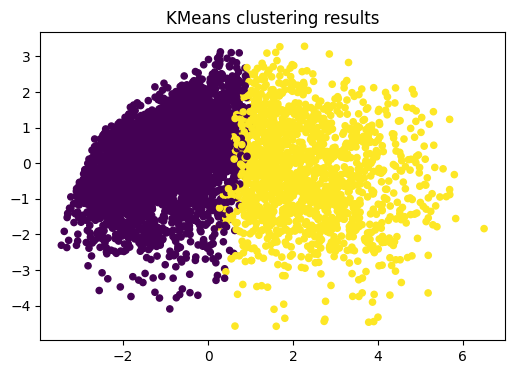

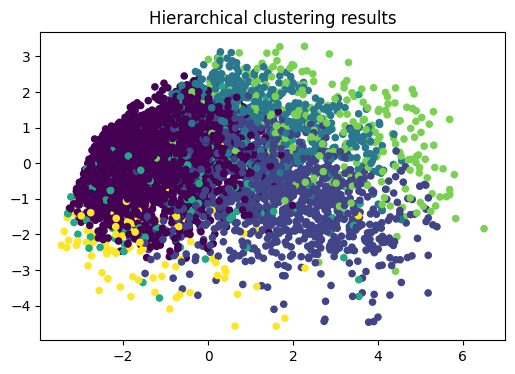

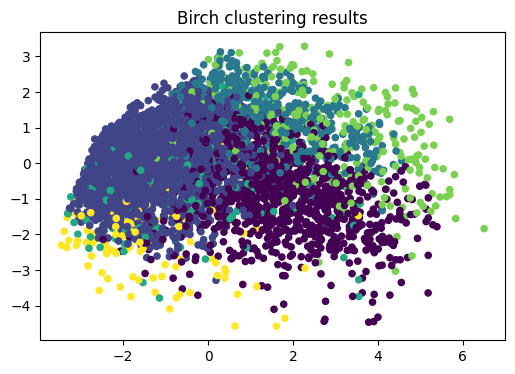

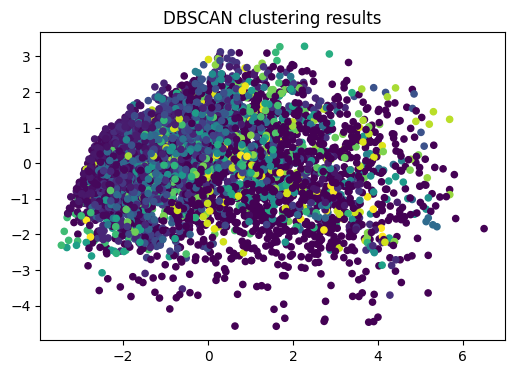

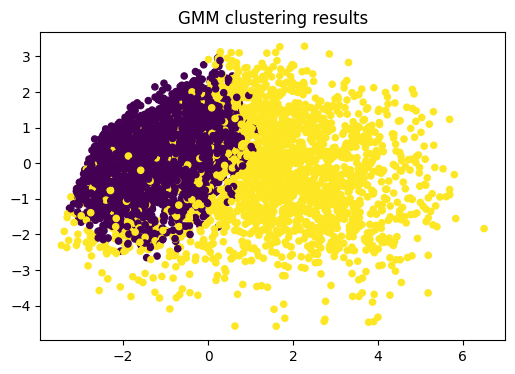

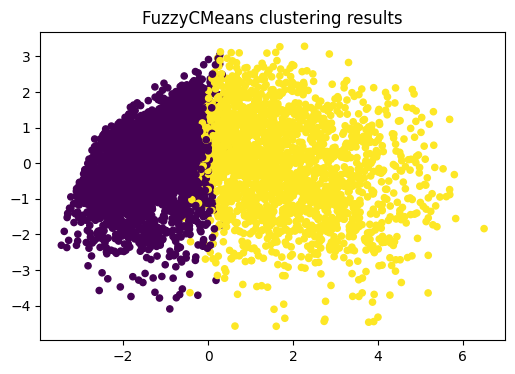

,Algorithm,Silhouette,Davies-Bouldin,ARI,NMI
0,KMeans,0.111817,1.947053,0.021515,0.066152
1,Hierarchical,0.085537,2.019390,0.019412,0.053934
2,DBSCAN,-0.068934,1.302625,0.000395,0.025348
3,FuzzyCMeans,0.142584,2.496866,0.154402,0.117300
4,GMM,0.085685,1.894113,0.018527,0.061871
5,BIRCH,0.089333,2.029169,0.018249,0.053360
6,KMeans,0.183761,2.333949,0.096678,0.088095
7,Hierarchical,0.180464,1.841790,0.047779,0.055805
8,Birch,0.181377,1.822503,0.050111,0.057561
9,DBSCAN,0.076226,1.541310,0.012038,0.055822


In [176]:
for name, model in models:
    if name == 'FuzzyCMeans':
        model.fit(X)
        labels = model.u.argmax(axis=1)
    elif name == 'GMM':
        labels = model.fit_predict(X)
    else:
        labels = model.fit_predict(X)
    labels_store[name] = labels

    plt.figure(figsize=(6,4))
    plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, s=20)
    plt.title(f'{name} clustering results')
    plt.show()

    metrics = {
        'Algorithm': name,
        'Silhouette': silhouette_score(X, labels),
        'Davies-Bouldin': davies_bouldin_score(X, labels)
    }
    metrics['ARI'] = adjusted_rand_score(y_true, labels)
    metrics['NMI'] = normalized_mutual_info_score(y_true, labels)
    results.append(metrics)

metrics_df = pd.DataFrame(results)
display(metrics_df)

In [177]:
# Cluster evaluation metrics range and goal
metric_ranges = {
    "Silhouetter Score:" : ("From [-1,1], As close to 1 as possible",
              "Measures how similar an object is to its own cluster, compared to other clusters"),
    "Davies-Bouldin:" : ("From [0, inf], As close to 0 as possible,",
              "Ratio of within-cluster scatter to between-cluster seperation"),
    "ARI:" : ("From [-1,1], As close to 1 as possible",
             "Compares the clusters to a known ground truth, adjusted for chance."),
    "NMI:" : ("From [0,1], As close to 1 as possible",
             "Measures shared information between clustering and ground truth, normalized to [0,1]")
}

for metric_ranges in metric_ranges.items():
  print(metric_ranges[0], metric_ranges[1][0])

Silhouetter Score: From [-1,1], As close to 1 as possible
Davies-Bouldin: From [0, inf], As close to 0 as possible,
ARI: From [-1,1], As close to 1 as possible
NMI: From [0,1], As close to 1 as possible


In [178]:
# Summarize centroids and sizes
for name, model in models:
    if name == 'DBSCAN': continue
    if name == 'FuzzyCMeans': labels = model.u.argmax(axis=1)
    elif name == 'GMM': labels = model.predict(X)
    else: labels = model.labels_ if hasattr(model, 'labels_') else model.fit_predict(X)
    df = pd.DataFrame(X, columns=FEATURES)
    df['cluster'] = labels
    summary = df.groupby('cluster').mean()
    summary['size'] = df.groupby('cluster').size()
    print(f'{name} centroids & sizes:')
    display(summary.round(2))

KMeans centroids & sizes:


,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,size
cluster,,,,,,,,,,,,,,,,,,
0,-0.14,0.03,-0.18,-0.05,-0.19,-0.12,-0.24,0.24,0.09,0.11,0.04,-0.42,-0.25,-0.43,-0.49,-0.20,-0.23,3480
1,0.32,-0.08,0.42,0.10,0.44,0.28,0.55,-0.55,-0.20,-0.24,-0.08,0.96,0.58,0.98,1.12,0.46,0.53,1520


Hierarchical centroids & sizes:


,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,size
cluster,,,,,,,,,,,,,,,,,,
0,-0.16,0.01,-0.17,0.16,-0.15,-0.16,-0.41,0.20,0.08,0.06,-0.20,-0.42,-0.33,-0.45,-0.58,-0.26,-0.22,2786
1,0.12,-0.25,0.22,0.16,0.40,0.14,-0.20,-0.35,-0.14,-0.07,-0.20,0.70,0.80,0.87,1.14,-0.25,0.30,1151
2,0.65,0.36,0.41,0.16,0.02,0.30,2.46,-0.13,-0.03,-0.08,-0.20,0.47,-0.31,0.25,0.32,-0.26,0.46,453
3,-0.29,0.22,-0.14,0.16,-0.30,0.34,-0.10,0.01,-0.15,0.14,4.95,-0.24,0.02,-0.21,-0.27,-0.08,-0.21,187
4,0.46,0.13,0.39,0.16,0.17,0.25,1.01,-0.32,-0.02,-0.24,-0.20,0.80,0.37,0.72,0.79,3.84,0.58,304
5,-0.67,0.03,-0.60,-6.40,-0.32,-0.00,-0.29,0.07,-0.00,-0.05,0.19,-0.31,0.07,-0.28,-0.34,-0.16,-0.59,119


Birch centroids & sizes:


,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,size
cluster,,,,,,,,,,,,,,,,,,
0,0.13,-0.26,0.23,0.16,0.35,0.15,-0.22,-0.36,-0.17,-0.07,-0.20,0.71,0.82,0.86,1.16,-0.26,0.32,1133
1,-0.16,0.02,-0.17,0.16,-0.14,-0.16,-0.41,0.20,0.08,0.06,-0.20,-0.42,-0.33,-0.44,-0.58,-0.26,-0.23,2795
2,0.64,0.35,0.42,0.16,0.06,0.30,2.46,-0.14,-0.01,-0.06,-0.20,0.48,-0.31,0.24,0.31,-0.26,0.47,461
3,-0.29,0.22,-0.14,0.16,-0.30,0.34,-0.10,0.01,-0.15,0.14,4.95,-0.24,0.02,-0.21,-0.27,-0.08,-0.21,187
4,0.46,0.14,0.38,0.16,0.19,0.25,1.00,-0.32,-0.01,-0.25,-0.20,0.80,0.38,0.72,0.79,3.84,0.58,305
5,-0.67,0.03,-0.60,-6.40,-0.32,-0.00,-0.29,0.07,-0.00,-0.05,0.19,-0.31,0.07,-0.28,-0.34,-0.16,-0.59,119


GMM centroids & sizes:


,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,size
cluster,,,,,,,,,,,,,,,,,,
0,-0.11,0.0,-0.17,0.16,-0.22,-0.17,-0.32,0.30,0.14,0.16,-0.20,-0.45,-0.32,-0.44,-0.47,-0.26,-0.23,2929
1,0.16,-0.0,0.24,-0.22,0.31,0.24,0.45,-0.42,-0.19,-0.23,0.29,0.63,0.45,0.63,0.67,0.37,0.32,2071


FuzzyCMeans centroids & sizes:


,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,size
cluster,,,,,,,,,,,,,,,,,,
0,-0.24,0.01,-0.34,-0.06,-0.28,-0.19,-0.32,0.34,0.15,0.17,0.03,-0.55,-0.27,-0.45,-0.52,-0.21,-0.42,2860
1,0.32,-0.01,0.45,0.08,0.38,0.26,0.43,-0.46,-0.20,-0.23,-0.04,0.73,0.36,0.60,0.69,0.28,0.56,2140
